# Feed-forward Neural Network

In diesem Notebook schauen wir Neurale Netzwerke an.
In der Praxis verwendet man für Bilderdaten üblicherweise Convolutional Neural Network (CNN), diese haben wir im Theorie Teil aber nicht im Detail angeschaut.
Daher verwenden wir hier die Feed-forward Neural Networks mit einem Hidden Layer.

Das Neural Network ist in `tensorflow` programmiert.

In [1]:
!pip install tensorflow

You should consider upgrading via the '/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, activations, Sequential, losses
from tensorflow.keras.regularizers import L2

import pickle

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Prepare data

In [5]:
# Load the data and split into features and labels
with open('../../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

##### Preprocessing

Für tensorflow müssen wir die Text-Labels (wie `frog`) in Zahlen verwandeln, dazu verwenden wir den `LabelEncoder`.

Die Daten werden hier mittels `tf.image.per_image_standardization` standartisiert.

In [7]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [8]:
# tf.image.per_image_standardization ist ein übliches Preprocessing für Bilderdaten.
X_train_std = tf.image.per_image_standardization(X_train).numpy()
X_val_std = tf.image.per_image_standardization(X_val).numpy()

2021-10-29 13:18:09.362728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### NN (0 hidden layer -> Logistic Regression)

Zuerst bauen wir die `Logistic Regression` als Neural Network nach.

Die Performanz sollte ähnlich sein zu unserer `Logistic Regression` Baseline.

2021-10-29 13:18:11.304552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
293/293 [==============================] - 1s 2ms/step - loss: 2.1450 - accuracy: 0.3230 - val_loss: 2.0046 - val_accuracy: 0.3631
Epoch 2/40
293/293 [==============================] - 0s 1ms/step - loss: 1.9692 - accuracy: 0.3713 - val_loss: 1.9439 - val_accuracy: 0.3742

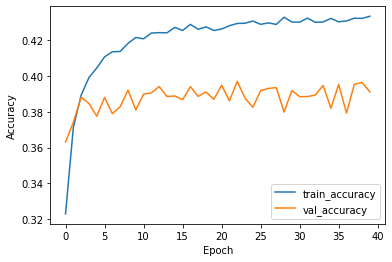

0.39104


In [9]:
lr = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(), name='output_layer'),
])
lr.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = lr.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = lr.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) no Regularization

Nun fügen wir einen `Hidden Layer` hinzu.

Epoch 1/40
293/293 [==============================] - 4s 13ms/step - loss: 1.7980 - accuracy: 0.3723 - val_loss: 1.6366 - val_accuracy: 0.4230

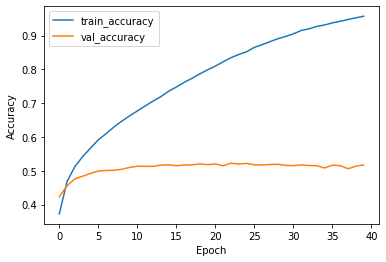

0.5168


In [10]:
nn = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, name='output_layer'),
])
nn.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = nn.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) with L2 Regularization

Nun fügen wir L2 Regularisierung hinzu, um gegen das Overfitting zu helfen.

Epoch 1/40
293/293 [==============================] - 7s 22ms/step - loss: 16.4562 - accuracy: 0.3714 - val_loss: 15.4510 - val_accuracy: 0.4250

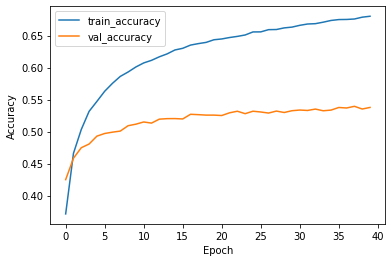

0.53776


In [11]:
nn_l2 = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, kernel_regularizer=L2(0.01), name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(0.01), name='output_layer'),
])
nn_l2.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = nn_l2.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn_l2.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

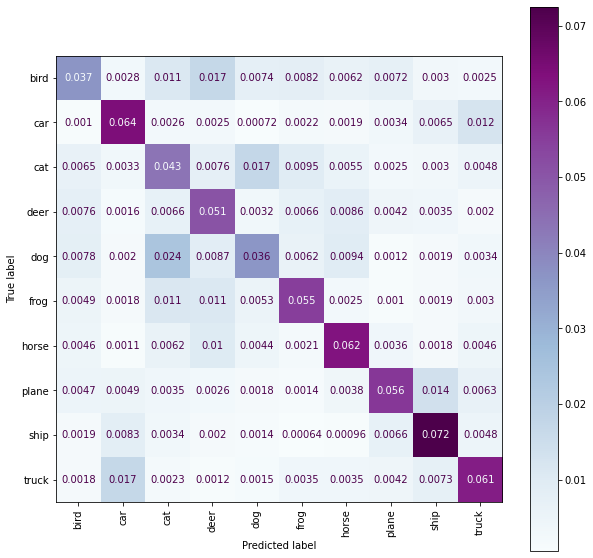

In [13]:
plot_confusion_matrix(
    y_true=y_val,
    y_pred=le.inverse_transform(y_val_hat)
)

# Predict classes for test set

If we are happy with the performance of our model on the validation set, we can apply it to the test set.

In [14]:
with open('../../data/test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [15]:
y_test_pred_prob = nn_l2.predict(X_test.reshape(-1, 32 * 32 * 3))
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_pred_enc = le.inverse_transform(y_test_pred)
y_test_pred_df = pd.DataFrame(y_test_pred_enc, columns=['label'])

To submit the predictions to Kaggle we write them into a .csv file, which you can manually submit.

In [16]:
y_test_pred_df.to_csv('../../out/neural_network.csv', header=True, index_label='id')